In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

# Analysis of Real Estate Data and Covid in the Manhattan area

In [22]:
# We first import the data
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df = rent_df.astype({
    'area': np.float64,
    'beds': np.float64,
    'baths': np.float64,
})
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'status_type', 'zip_code'], axis=1)

The structure of the data is:

In [23]:
rent_df

date event_description  price address_city    area      home_type  \
0     2021-04-16   Listed for rent   1500      Maspeth     NaN      APARTMENT   
1     2021-03-03      Price change   1300      Maspeth   350.0      APARTMENT   
2     2021-02-17   Listed for rent   1350      Maspeth   350.0      APARTMENT   
3     2021-04-10   Listed for rent   3000      Maspeth     NaN   MULTI_FAMILY   
4     2021-03-23   Listed for rent   3200     Flushing  3000.0  SINGLE_FAMILY   
...          ...               ...    ...          ...     ...            ...   
48316 2021-03-13  No price history   2500      Bayside  1100.0      APARTMENT   
48317 2021-03-12  No price history   2400      Bayside     NaN      APARTMENT   
48318 2021-02-01  No price history   2299      Bayside  1000.0   MULTI_FAMILY   
48319 2021-01-04  No price history   2274      Bayside     NaN   MULTI_FAMILY   
48320 2020-01-21  No price history   2500      Bayside     NaN   MULTI_FAMILY   

      borough  
0      queens  
1      queens  
2      queens  
3      queens  
4      queens  
...       ...  
48316  queens  
48317  queens  
48318  queens  
48319  queens  
48320  queens  

[48321 rows x 7 columns]

We divide the data into boroughs to analyze them individually

In [24]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

Our analysis for real estate data starts from 01/01/2020 so we need to remove the properties with a date
before 01/01/2020


# Time Series Analysis on Manhattan

In [25]:
current_borough = 'bronx'
rent_df = rent_ny[current_borough]
print(rent_df['price'].describe())

count     1708.000000
mean      2184.759953
std        685.228838
min        850.000000
25%       1755.000000
50%       2044.000000
75%       2500.000000
max      10000.000000
Name: price, dtype: float64


Remove outliers from the data

In [26]:
rent_df.drop(rent_df[rent_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
rent_ts = rent_df.groupby(rent_df.date)['price'].agg(['mean','count', 'median'])
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 4, 1)
idx = pd.date_range(start, end)
rent_ts = rent_ts[(rent_ts.index >= start) & (rent_ts.index <= end)]
rent_ts = rent_ts.reindex(idx)
rent_ts = rent_ts.rename({
    'mean': 'mean_price',
    'count': 'rent_count',
    'median': 'median_price'
}, axis=1)
rent_ts

mean_price  rent_count  median_price
2020-01-01          NaN         NaN           NaN
2020-01-02          NaN         NaN           NaN
2020-01-03          NaN         NaN           NaN
2020-01-04          NaN         NaN           NaN
2020-01-05          NaN         NaN           NaN
...                 ...         ...           ...
2021-03-28  2250.600000        15.0        2000.0
2021-03-29  2227.296296        27.0        2000.0
2021-03-30  1987.458333        24.0        1875.0
2021-03-31  2532.555556        18.0        2233.5
2021-04-01  2097.705882        17.0        2100.0

[457 rows x 3 columns]

Raw time series for Manhattan

<AxesSubplot:>

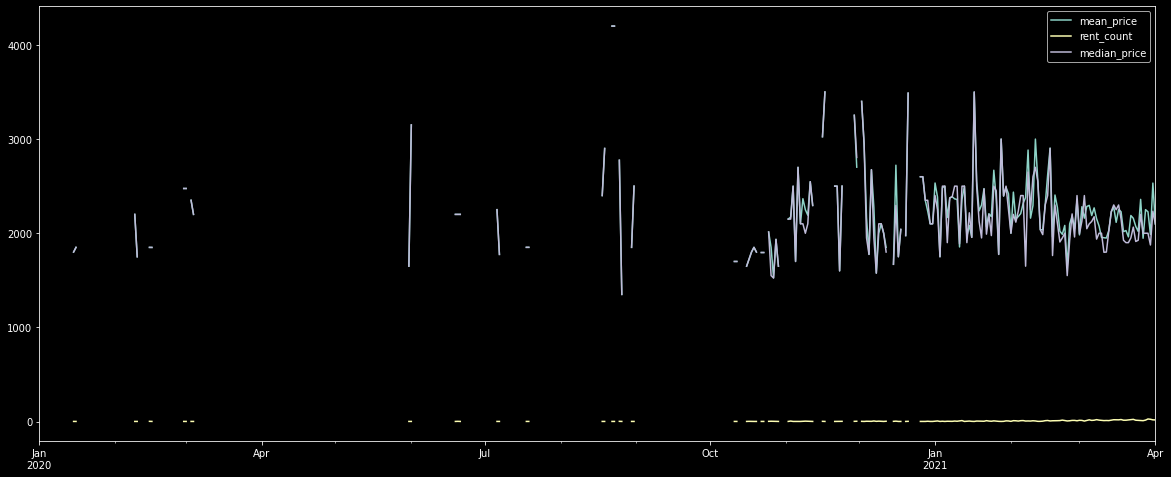

In [28]:
rent_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [29]:
rent_ts = rent_ts.interpolate(method='spline', order=2)

<AxesSubplot:>

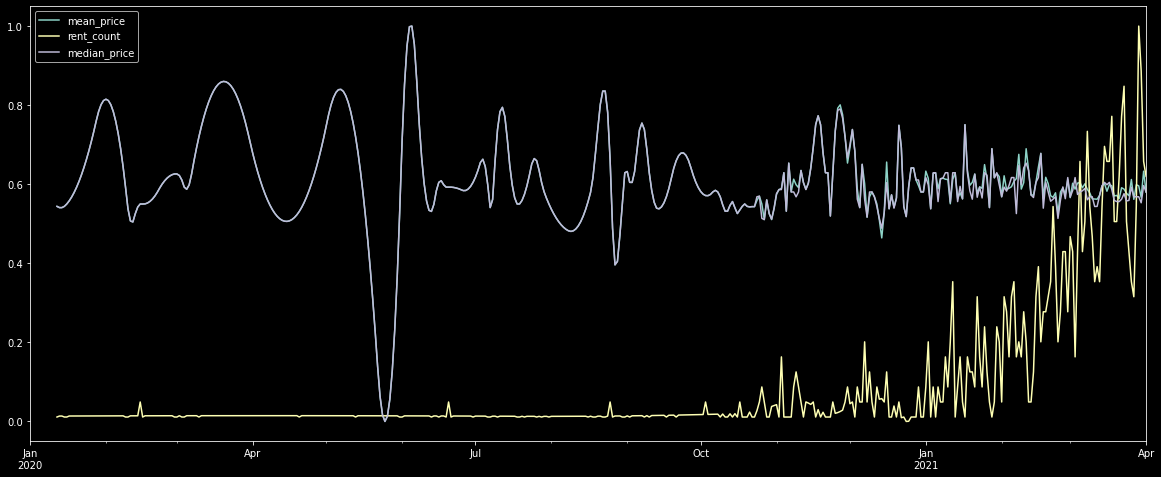

In [30]:
scaler = MinMaxScaler()
rent_ts = pd.DataFrame(scaler.fit_transform(rent_ts), index=rent_ts.index, columns=rent_ts.columns)
rent_ts.plot()

Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

We might need to use a trailing window because we are trying to forecast into the future.

Comparison between different smoothing options:

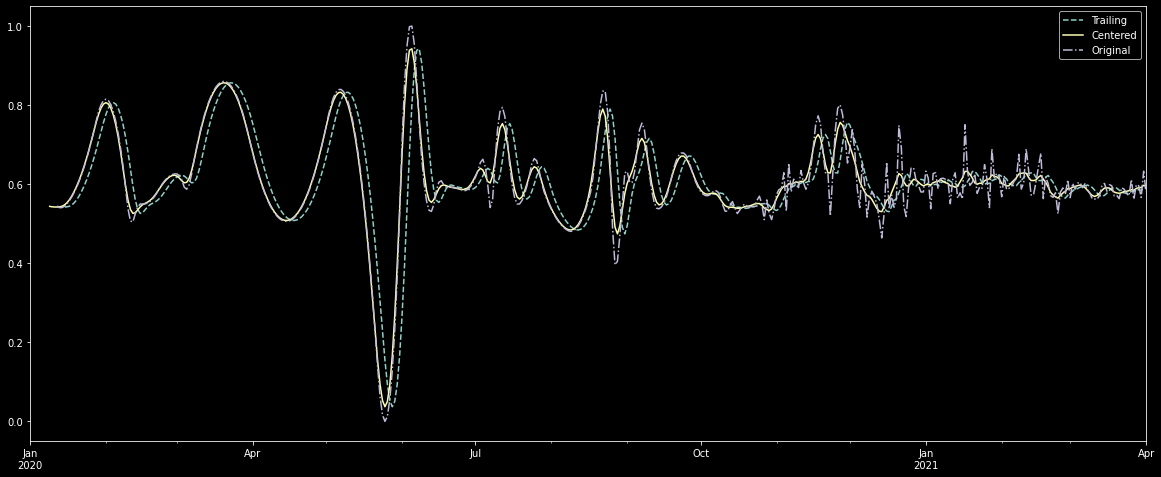

In [31]:
fig, ax = plt.subplots()
smoothed_ts = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1).mean()
smoothed_ts.plot(style='--', legend=True, ax=ax)
smoothed_ts_centered = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1, center=True).mean()
smoothed_ts_centered.plot(legend=True, ax=ax)
smoothed_ts_not_smoothed = rent_ts['mean_price']
smoothed_ts_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])


We also explore the price/sqr_feet

In [32]:
# we take the properties that actually have the area listed
price_sqft = rent_df[ ~rent_df['area'].isna() ].sort_values('date')
price_sqft['price_per_sqft'] = price_sqft['price']/price_sqft['area']

price_sqft = price_sqft.groupby(price_sqft.date)['price_per_sqft'].agg(['mean', 'median'])
price_sqft = price_sqft.rename({
    'mean': 'mean_price_per_sqft',
    'median': 'median_price_per_sqft'
}, axis=1)
price_sqft = price_sqft.reindex(idx)
price_sqft = price_sqft.interpolate(method='spline', order=2)
price_sqft = pd.DataFrame(scaler.fit_transform(price_sqft), index=price_sqft.index, columns=price_sqft.columns)
# price_sqft = price_sqft.rolling(7, win_type='triang', min_periods=1).mean()
rent_ts = pd.concat([rent_ts, price_sqft], axis=1)
rent_ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2020-01-01         NaN         NaN           NaN                  NaN   
2020-01-02         NaN         NaN           NaN                  NaN   
2020-01-03         NaN         NaN           NaN                  NaN   
2020-01-04         NaN         NaN           NaN                  NaN   
2020-01-05         NaN         NaN           NaN                  NaN   
...                ...         ...           ...                  ...   
2021-03-28    0.598720    0.543608      0.568266             0.528623   
2021-03-29    0.595888    1.000000      0.568266             0.473293   
2021-03-30    0.566741    0.885902      0.553075             0.440745   
2021-03-31    0.632985    0.657706      0.596642             0.550675   
2021-04-01    0.580139    0.619674      0.580418             0.453017   

            median_price_per_sqft  
2020-01-01                    NaN  
2020-01-02                    NaN  
2020-01-03                    NaN  
2020-01-04                    NaN  
2020-01-05                    NaN  
...                           ...  
2021-03-28               0.517717  
2021-03-29               0.455787  
2021-03-30               0.471416  
2021-03-31               0.589171  
2021-04-01               0.455787  

[457 rows x 5 columns]

# Introducing COVID data

In [33]:
nyc_covid_df = pd.read_csv("data/covid/covid_county.csv")
nyc_covid_df = nyc_covid_df[nyc_covid_df['countyname'] == 'Bronx']
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['county_pop2019', 'countyfips', 'cityname', 'countyname'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_ts = nyc_covid_df.set_index('date', drop=True)
nyc_covid_ts = nyc_covid_ts.rename({col: col + "_covid" for col in nyc_covid_ts.columns}, axis=1)

Covid raw data:

In [34]:
nyc_covid_ts

new_case_count_covid  new_death_count_covid  new_test_count_covid  \
date                                                                            
2020-01-22                     0                      0                     0   
2020-01-23                     0                      0                     0   
2020-01-24                     0                      0                     0   
2020-01-25                     0                      0                     0   
2020-01-26                     0                      0                     0   
...                          ...                    ...                   ...   
2021-03-28                   942                     11                 11565   
2021-03-29                  1105                     14                 11547   
2021-03-30                  1160                     14                 11257   
2021-03-31                   712                     10                 11038   
2021-04-01                   728                     11                 10501   

            new_case_rate_covid  new_death_rate_covid  new_test_rate_covid  \
date                                                                         
2020-01-22                  0.0                 0.000                  0.0   
2020-01-23                  0.0                 0.000                  0.0   
2020-01-24                  0.0                 0.000                  0.0   
2020-01-25                  0.0                 0.000                  0.0   
2020-01-26                  0.0                 0.000                  0.0   
...                         ...                   ...                  ...   
2021-03-28                 66.4                 0.785                815.0   
2021-03-29                 77.9                 1.020                814.0   
2021-03-30                 81.8                 1.020                794.0   
2021-03-31                 50.2                 0.715                778.0   
2021-04-01                 51.3                 0.796                740.0   

            case_count_covid  case_rate_covid  death_count_covid  \
date                                                               
2020-01-22                 0              0.0                  0   
2020-01-23                 0              0.0                  0   
2020-01-24                 0              0.0                  0   
2020-01-25                 0              0.0                  0   
2020-01-26                 0              0.0                  0   
...                      ...              ...                ...   
2021-03-28            158464          11174.0               6034   
2021-03-29            159569          11251.0               6049   
2021-03-30            160729          11333.0               6063   
2021-03-31            161441          11383.0               6073   
2021-04-01            162169          11435.0               6085   

            death_rate_covid  test_count_covid  test_rate_covid  
date                                                             
2020-01-22               0.0                 0              0.0  
2020-01-23               0.0                 0              0.0  
2020-01-24               0.0                 0              0.0  
2020-01-25               0.0                 0              0.0  
2020-01-26               0.0                 0              0.0  
...                      ...               ...              ...  
2021-03-28             425.0           2434833         171684.0  
2021-03-29             427.0           2446380         172498.0  
2021-03-30             428.0           2457637         173292.0  
2021-03-31             428.0           2468675         174070.0  
2021-04-01             429.0           2479176         174811.0  

[436 rows x 12 columns]

<AxesSubplot:xlabel='date'>

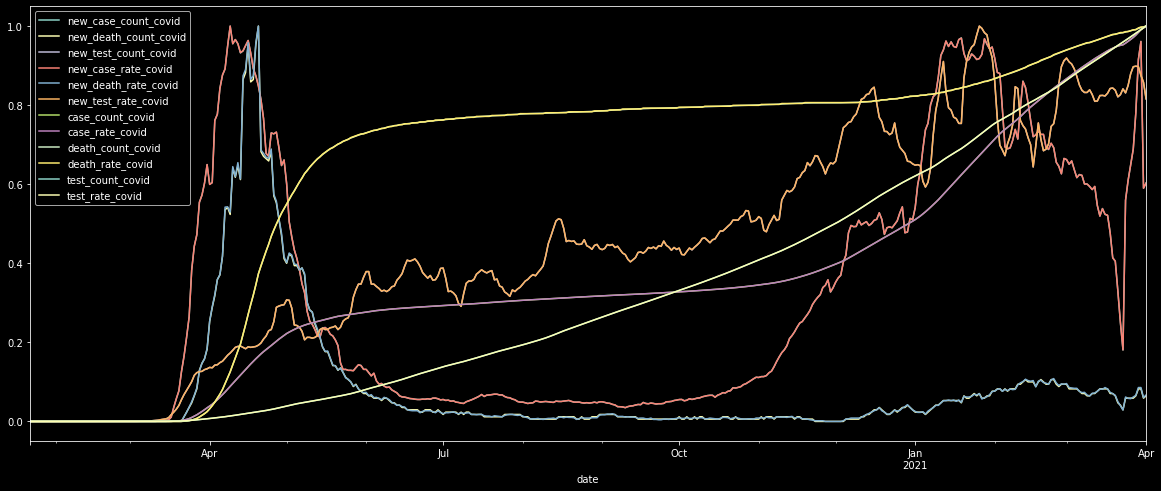

In [35]:
nyc_covid_ts = pd.DataFrame(scaler.fit_transform(nyc_covid_ts), columns=nyc_covid_ts.columns, index=nyc_covid_ts.index)
nyc_covid_ts.plot()


In [36]:
ts = pd.concat([rent_ts, nyc_covid_ts], axis=1)

In [37]:
ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2020-01-01         NaN         NaN           NaN                  NaN   
2020-01-02         NaN         NaN           NaN                  NaN   
2020-01-03         NaN         NaN           NaN                  NaN   
2020-01-04         NaN         NaN           NaN                  NaN   
2020-01-05         NaN         NaN           NaN                  NaN   
...                ...         ...           ...                  ...   
2021-03-28    0.598720    0.543608      0.568266             0.528623   
2021-03-29    0.595888    1.000000      0.568266             0.473293   
2021-03-30    0.566741    0.885902      0.553075             0.440745   
2021-03-31    0.632985    0.657706      0.596642             0.550675   
2021-04-01    0.580139    0.619674      0.580418             0.453017   

            median_price_per_sqft  new_case_count_covid  \
2020-01-01                    NaN                   NaN   
2020-01-02                    NaN                   NaN   
2020-01-03                    NaN                   NaN   
2020-01-04                    NaN                   NaN   
2020-01-05                    NaN                   NaN   
...                           ...                   ...   
2021-03-28               0.517717              0.780447   
2021-03-29               0.455787              0.915493   
2021-03-30               0.471416              0.961060   
2021-03-31               0.589171              0.589892   
2021-04-01               0.455787              0.603148   

            new_death_count_covid  ...  new_test_rate_covid  case_count_covid  \
2020-01-01                    NaN  ...                  NaN               NaN   
2020-01-02                    NaN  ...                  NaN               NaN   
2020-01-03                    NaN  ...                  NaN               NaN   
2020-01-04                    NaN  ...                  NaN               NaN   
2020-01-05                    NaN  ...                  NaN               NaN   
...                           ...  ...                  ...               ...   
2021-03-28               0.064706  ...             0.898567          0.977153   
2021-03-29               0.082353  ...             0.897464          0.983967   
2021-03-30               0.082353  ...             0.875413          0.991120   
2021-03-31               0.058824  ...             0.857773          0.995511   
2021-04-01               0.064706  ...             0.815877          1.000000   

            case_rate_covid  death_count_covid  death_rate_covid  \
2020-01-01              NaN                NaN               NaN   
2020-01-02              NaN                NaN               NaN   
2020-01-03              NaN                NaN               NaN   
2020-01-04              NaN                NaN               NaN   
2020-01-05              NaN                NaN               NaN   
...                     ...                ...               ...   
2021-03-28         0.977175           0.991619          0.990676   
2021-03-29         0.983909           0.994084          0.995338   
2021-03-30         0.991080           0.996385          0.997669   
2021-03-31         0.995453           0.998028          0.997669   
2021-04-01         1.000000           1.000000          1.000000   

            test_count_covid  test_rate_covid  
2020-01-01               NaN              NaN  
2020-01-02               NaN              NaN  
2020-01-03               NaN              NaN  
2020-01-04               NaN              NaN  
2020-01-05               NaN              NaN  
...                      ...              ...  
2021-03-28          0.982114         0.982112  
2021-03-29          0.986771         0.986769  
2021-03-30          0.991312         0.991311  
2021-03-31          0.995764         0.995761  
2021-04-01          1.000000         1.000000  

[457 rows x 17 columns]

<AxesSubplot:>

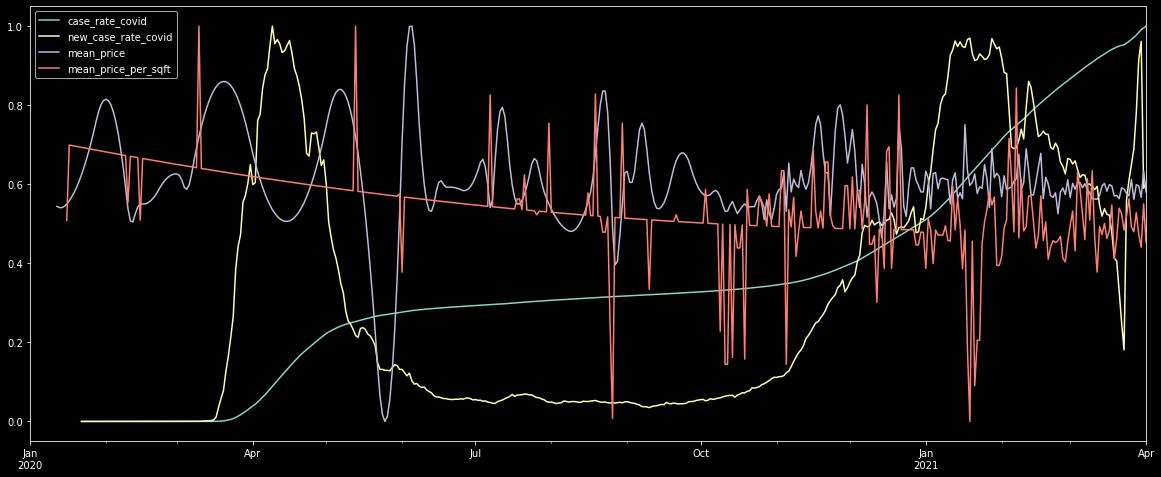

In [38]:
ts[['case_rate_covid', 'new_case_rate_covid', 'mean_price', 'mean_price_per_sqft']].plot()

# Seasonal Decompositions
Decomposition is the process of understanding generalizations and problems related to time-series forecasting.
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

First we explore the decompositions of COVID time series

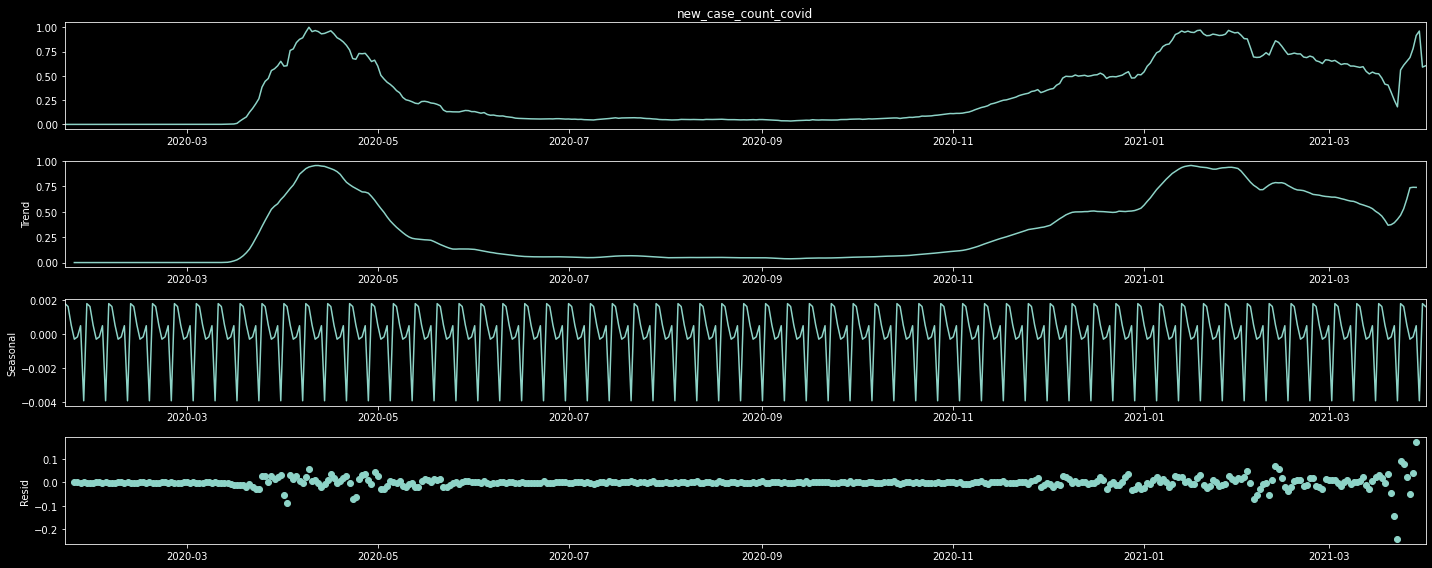

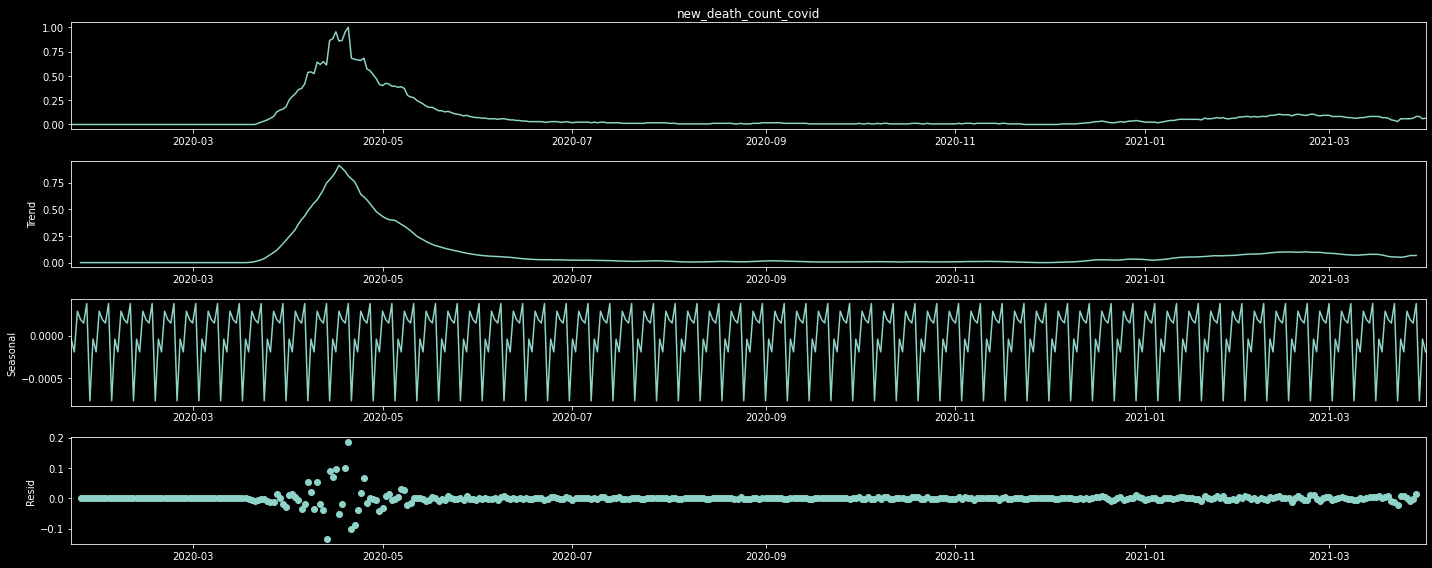

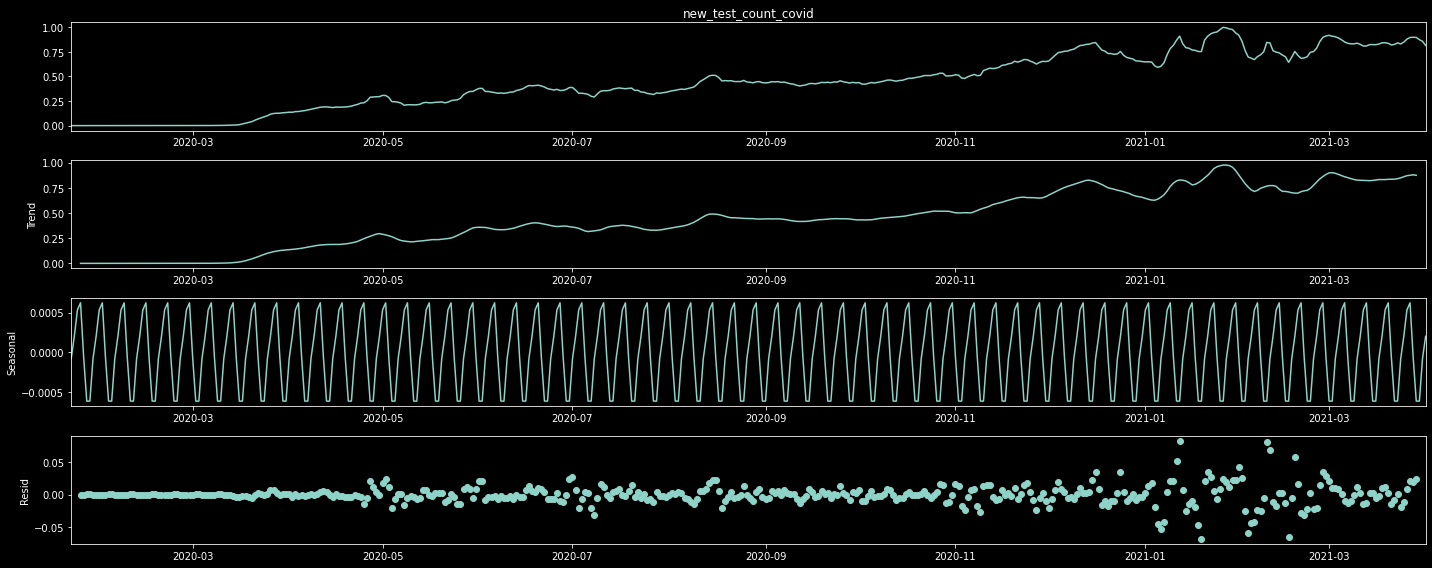

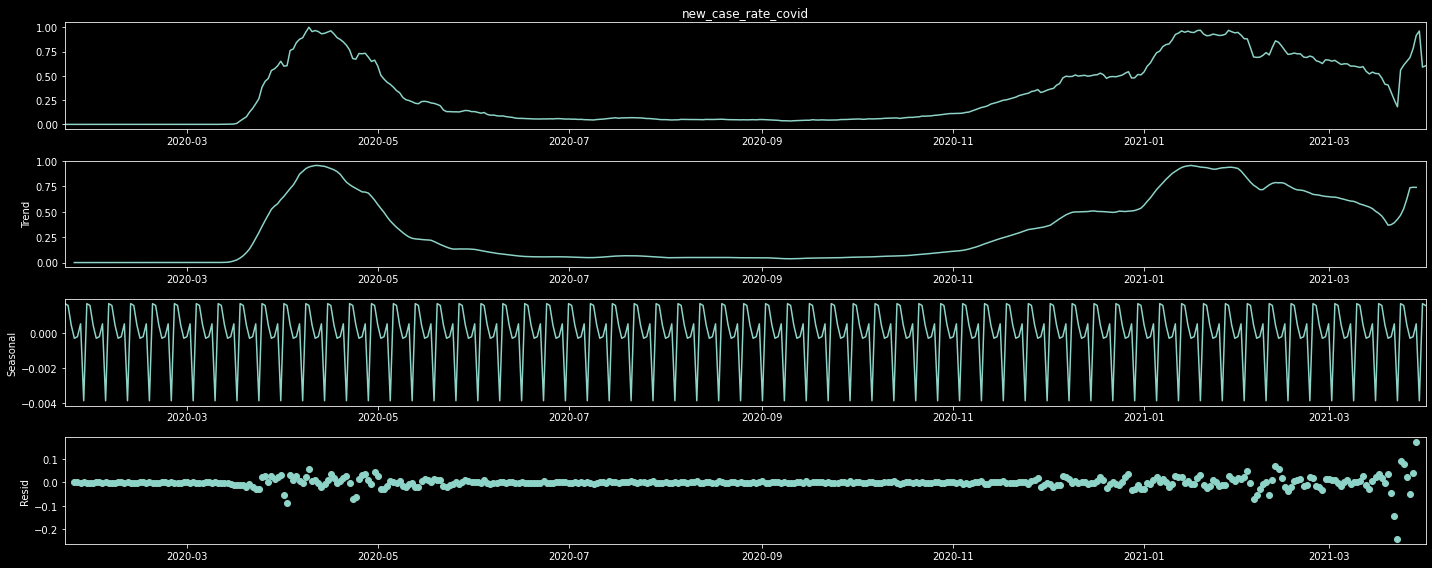

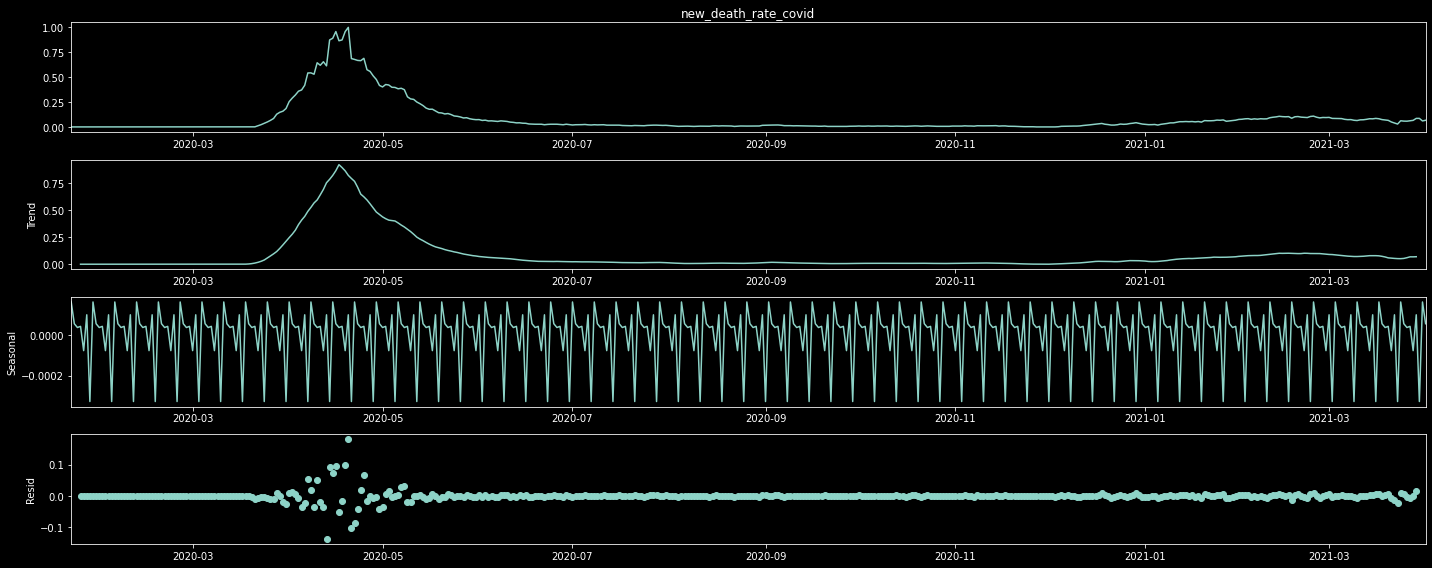

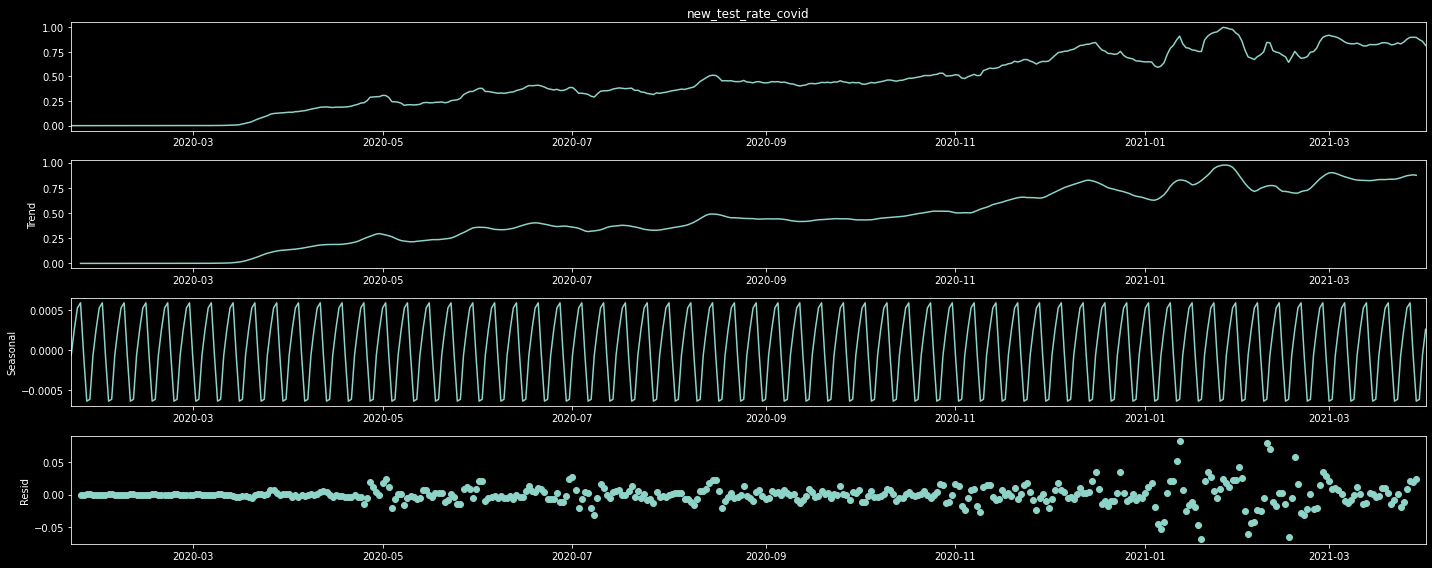

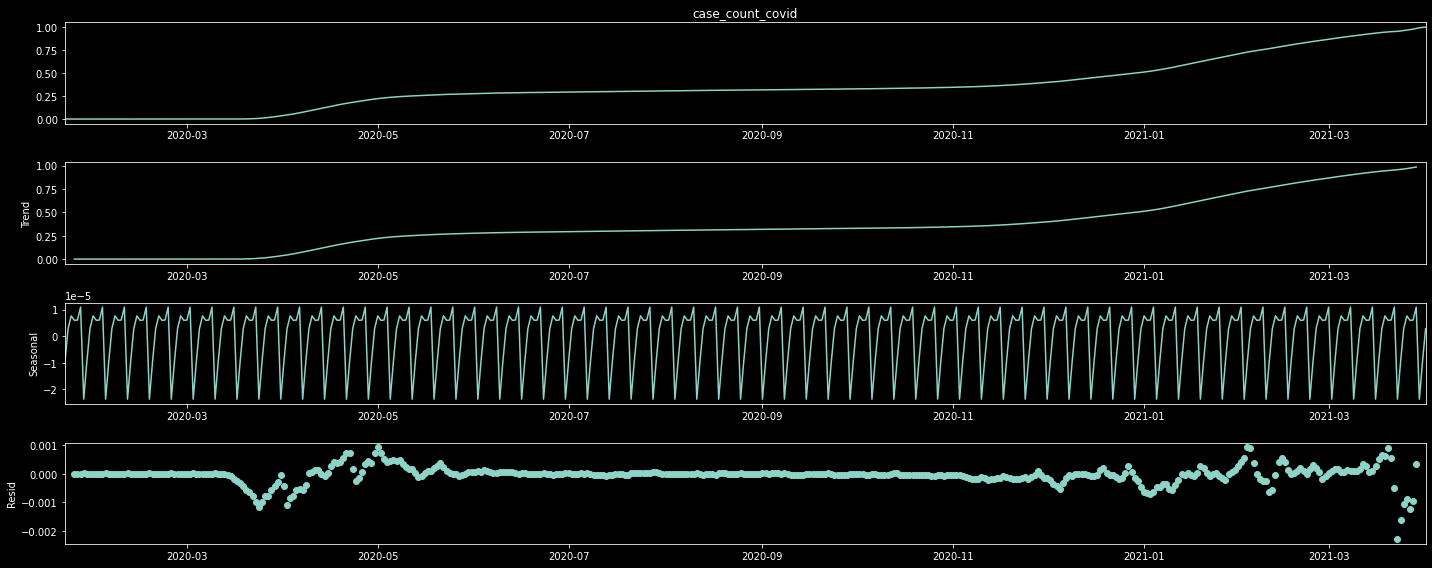

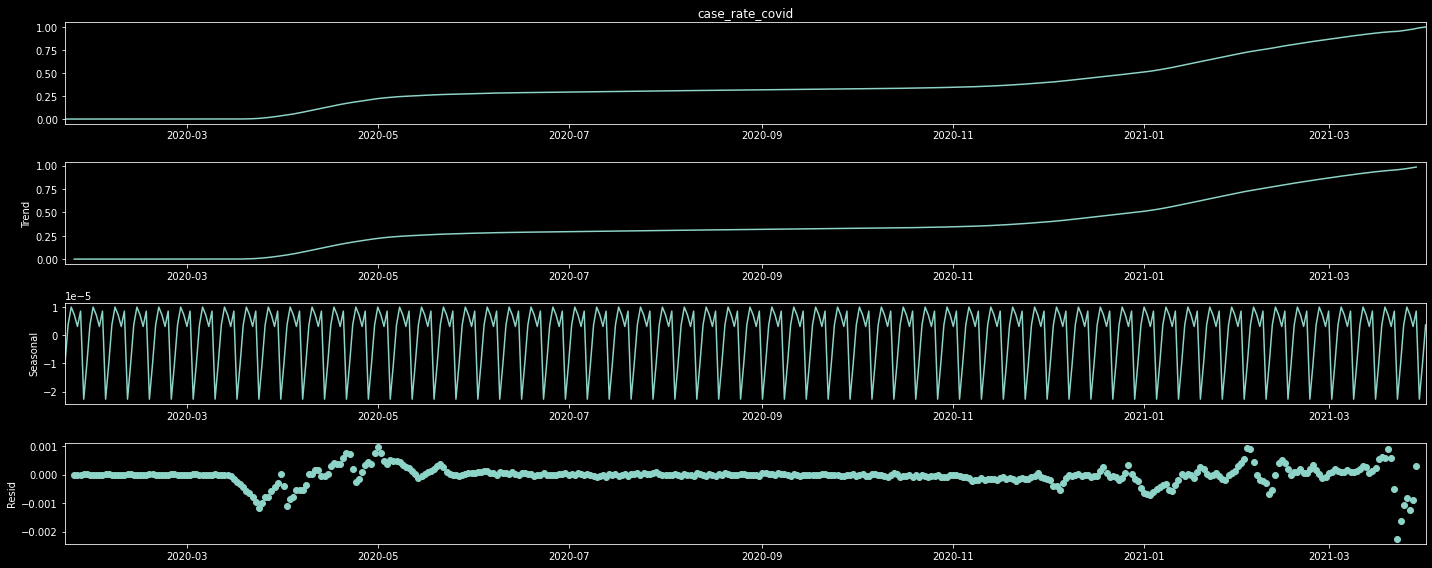

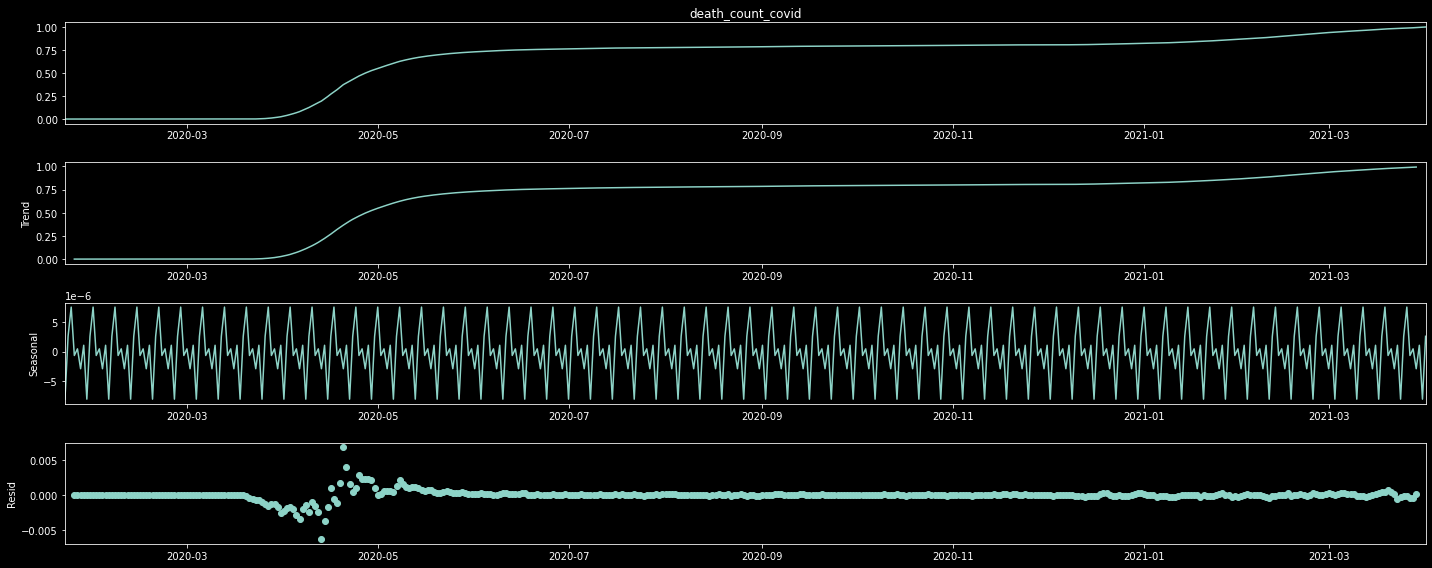

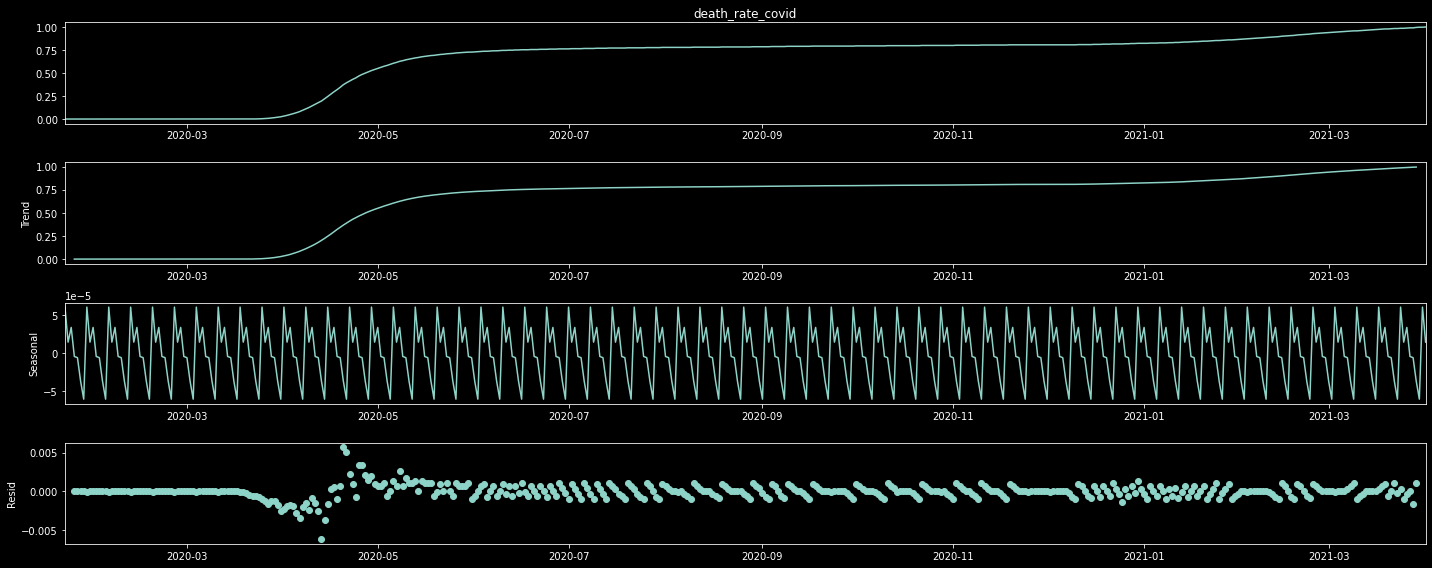

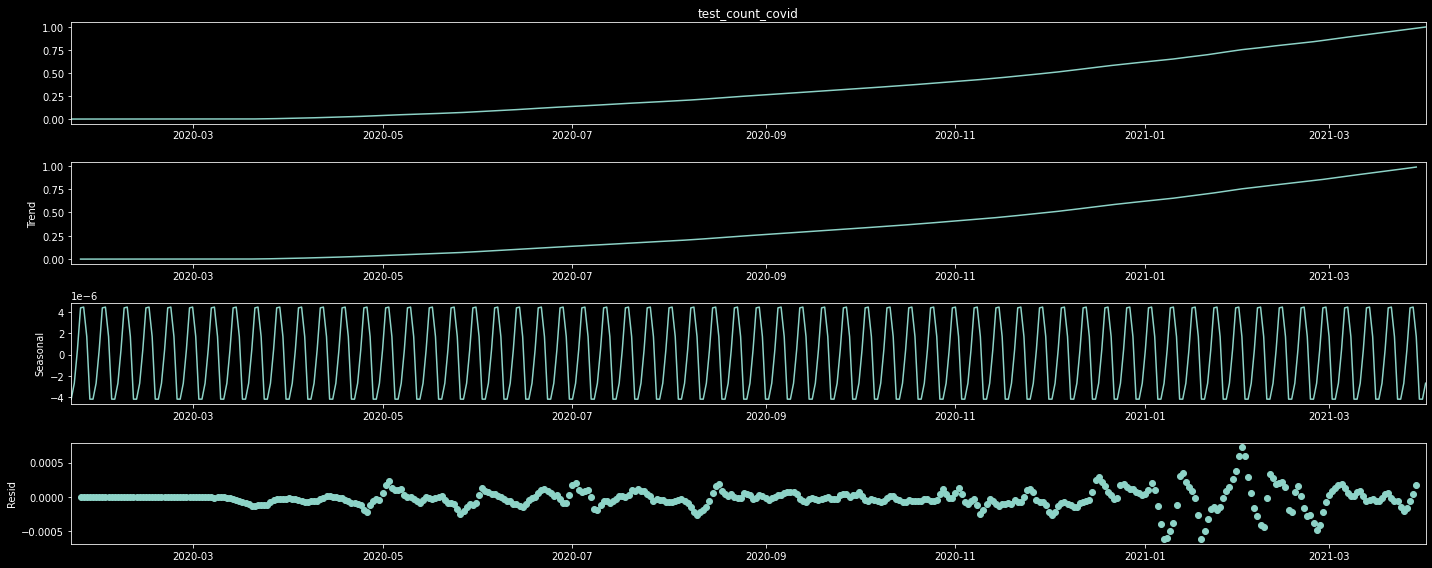

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals = dict()


legend = []
for col in ts.columns:
    if 'covid' in col:
        legend.append(col)
        covid_df = ts[col]
        covid_decomposition = seasonal_decompose(covid_df.drop(covid_df[covid_df.isna()].index), model='additive')
        residuals[col+'_resid'] = covid_decomposition.resid
        covid_decomposition.plot()

residuals_ts = pd.concat(residuals, axis=1)

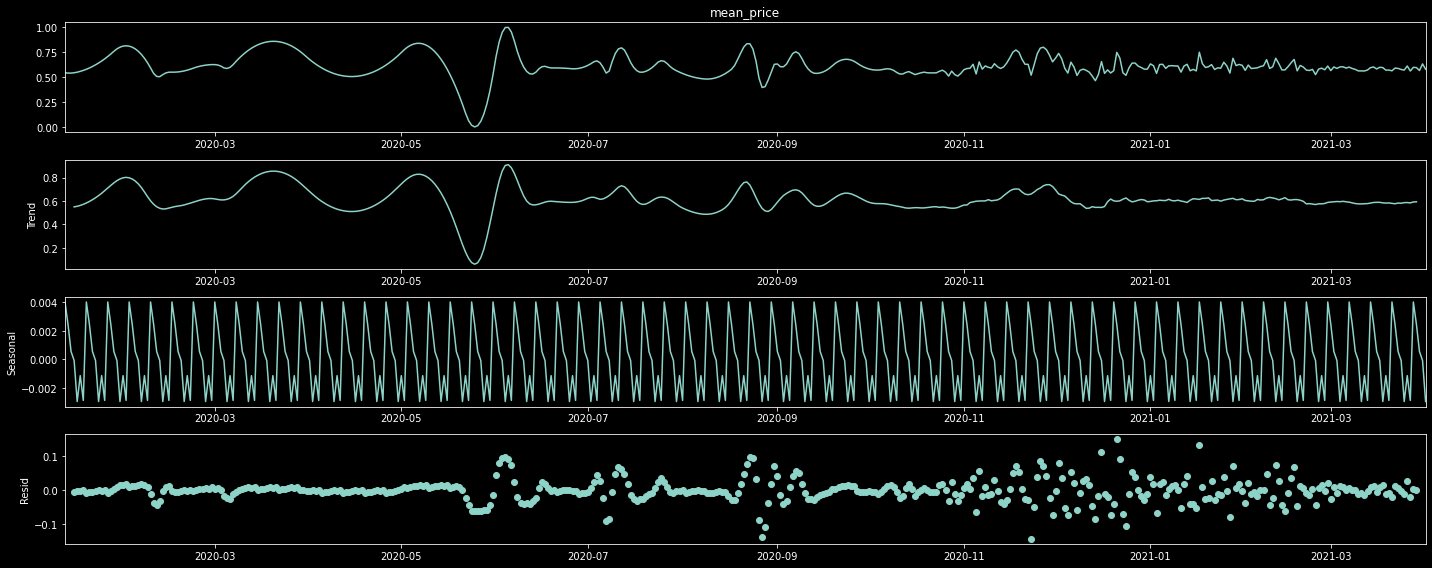

In [40]:
price = ts['mean_price']
price_decomposition = seasonal_decompose(price.drop(price[price.isna()].index), model='additive')
price_decomposition.plot()
plt.show()

In [41]:
ts = pd.concat([ts, residuals_ts, price_decomposition.resid.rename({'resid': 'mean_price_resid' }, axis=1)], axis=1)

<AxesSubplot:>

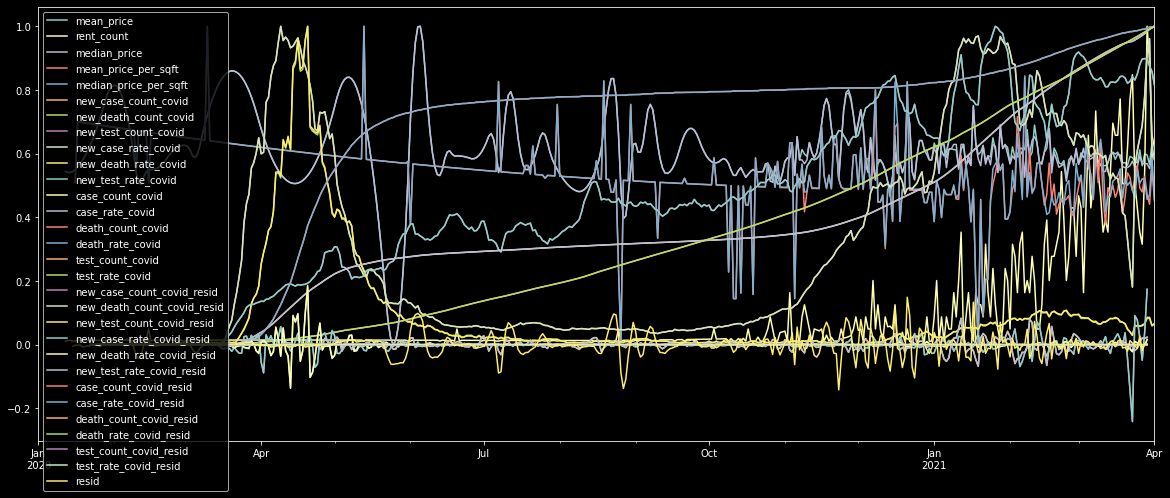

In [42]:
ts.plot()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

# covid case rate autocorrelation plot:

Ploting the PACF and ACF of case rate

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


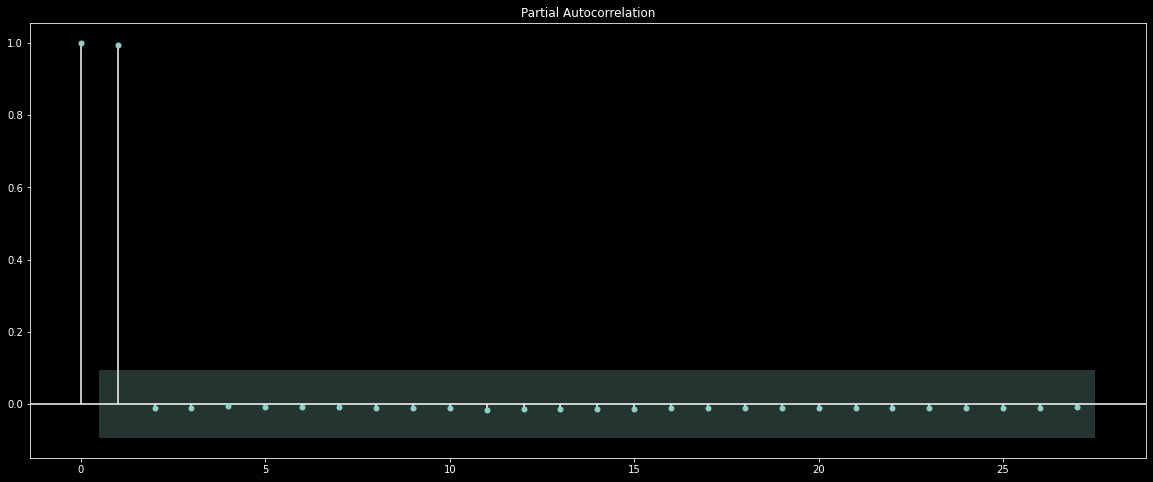

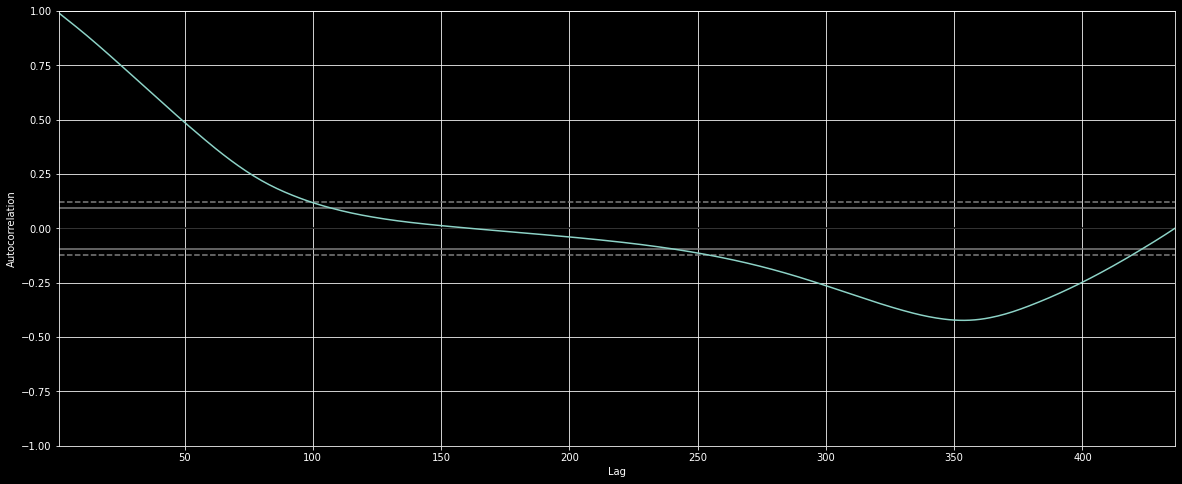

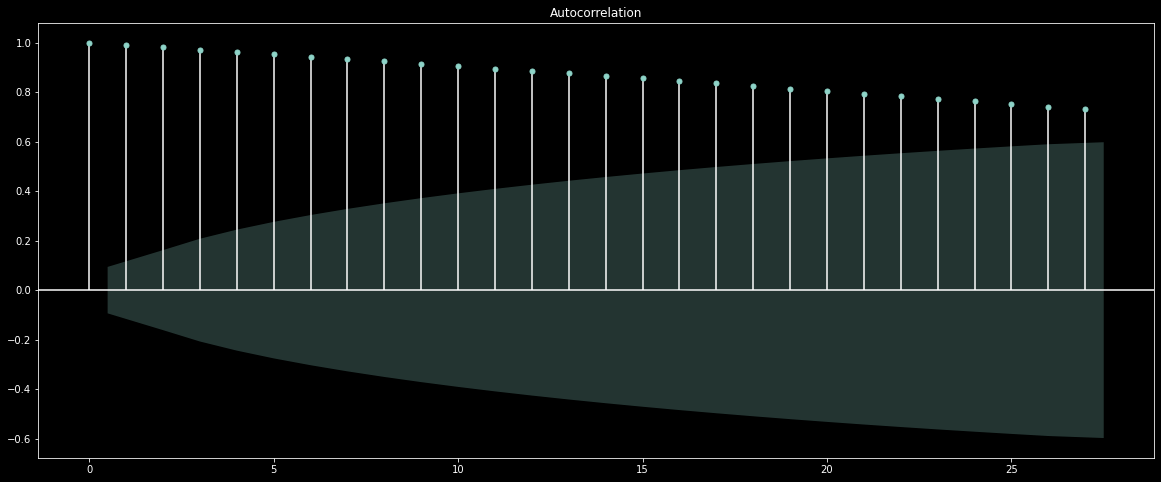

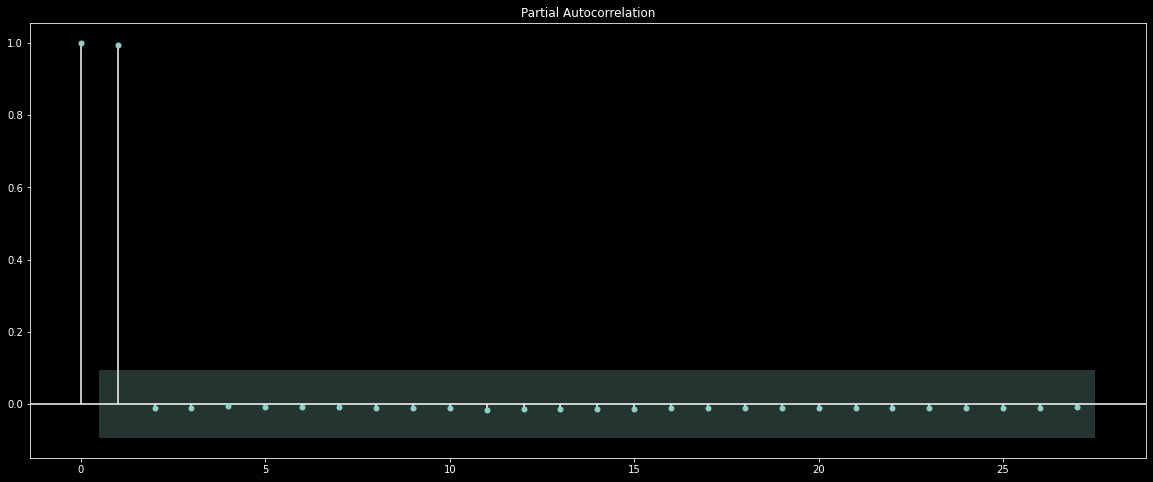

In [43]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

case_rate = ts[~ts['case_rate_covid'].isna()]['case_rate_covid']
autocorrelation_plot(case_rate.tolist())
plot_acf(case_rate)
plot_pacf(case_rate)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


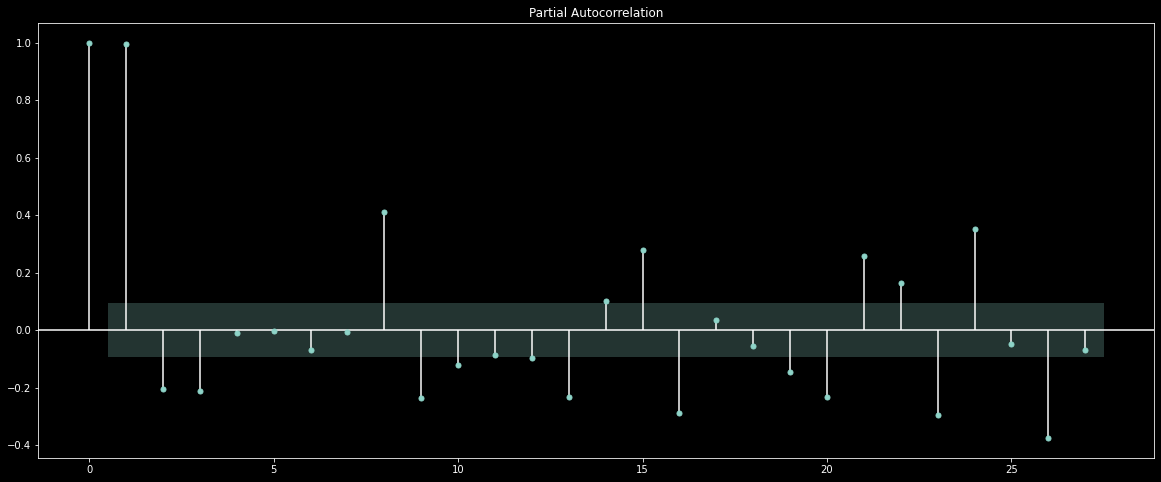

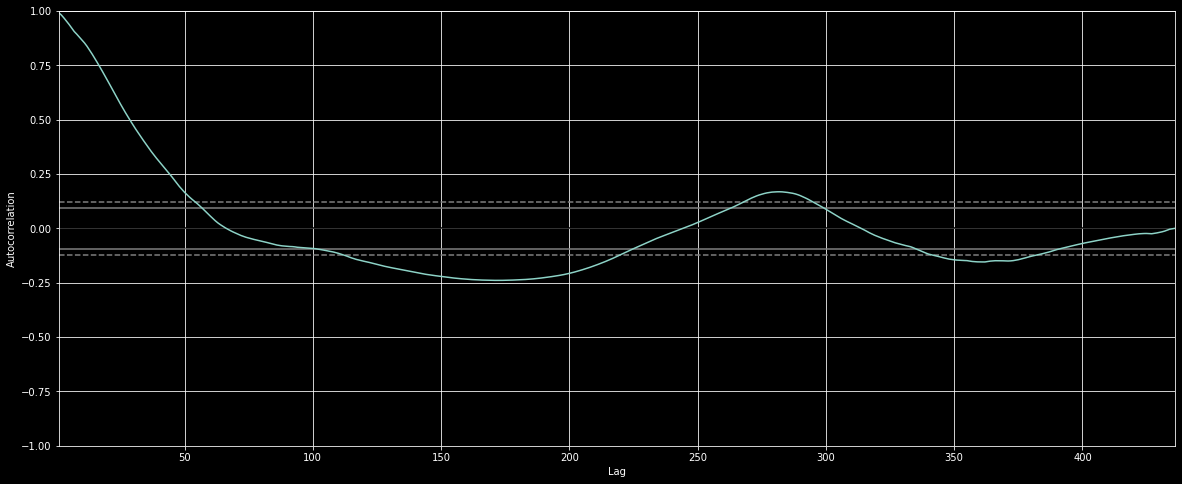

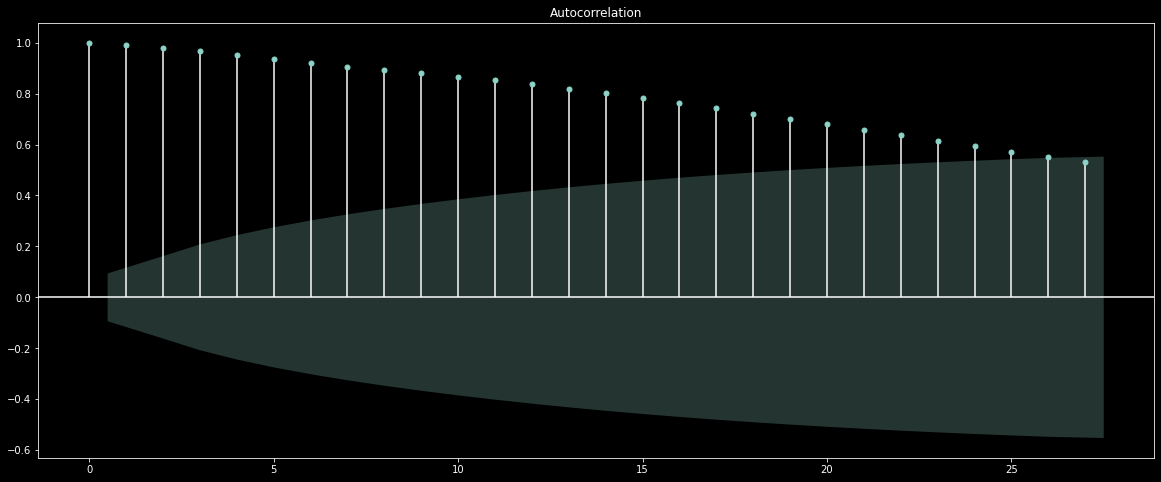

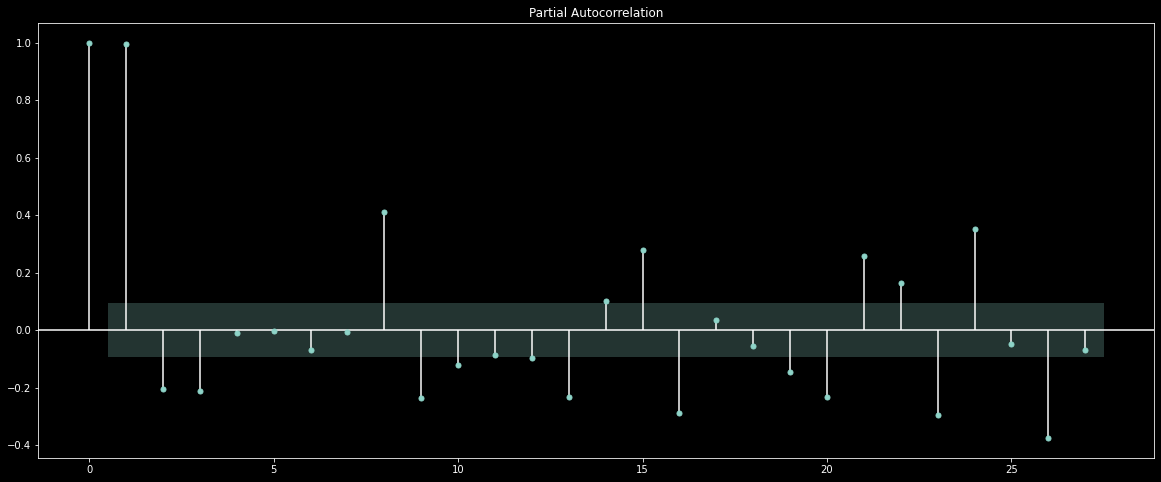

In [44]:
new_case_rate = ts[~ts['new_case_rate_covid'].isna()]['new_case_rate_covid']
autocorrelation_plot(new_case_rate.tolist())
plot_acf(new_case_rate)
plot_pacf(new_case_rate)

Ploting the PACF and ACF of mean price and number of properties for rent

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


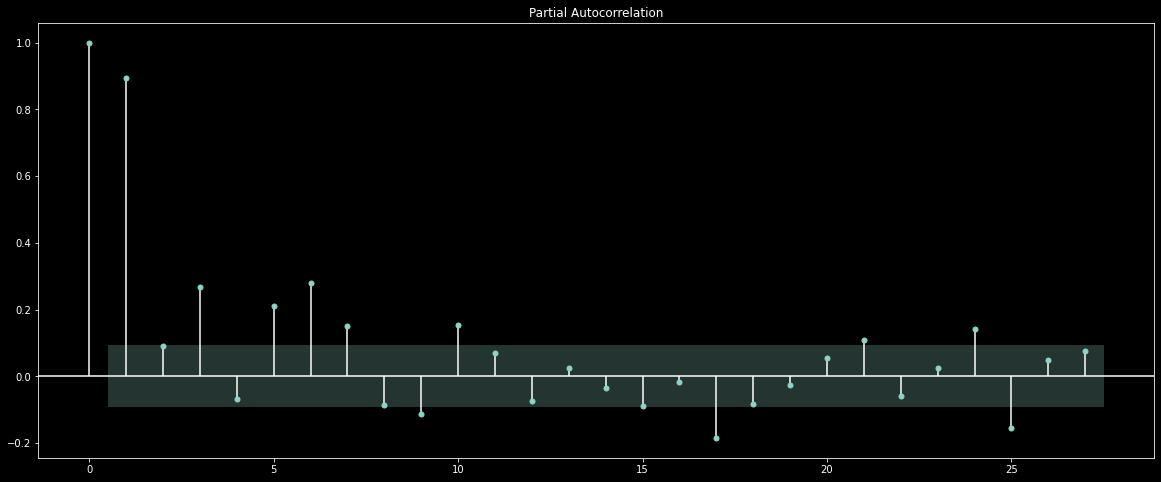

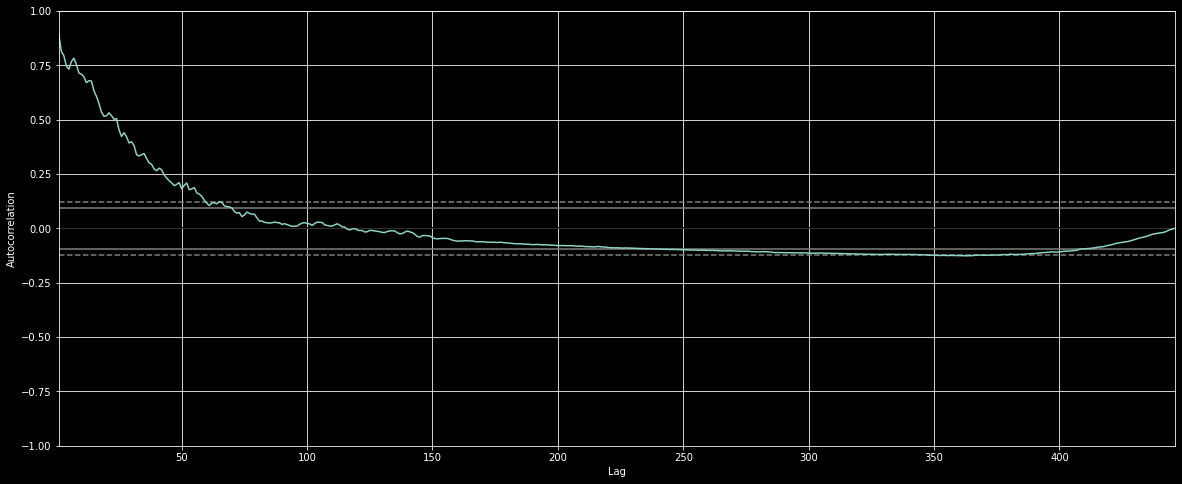

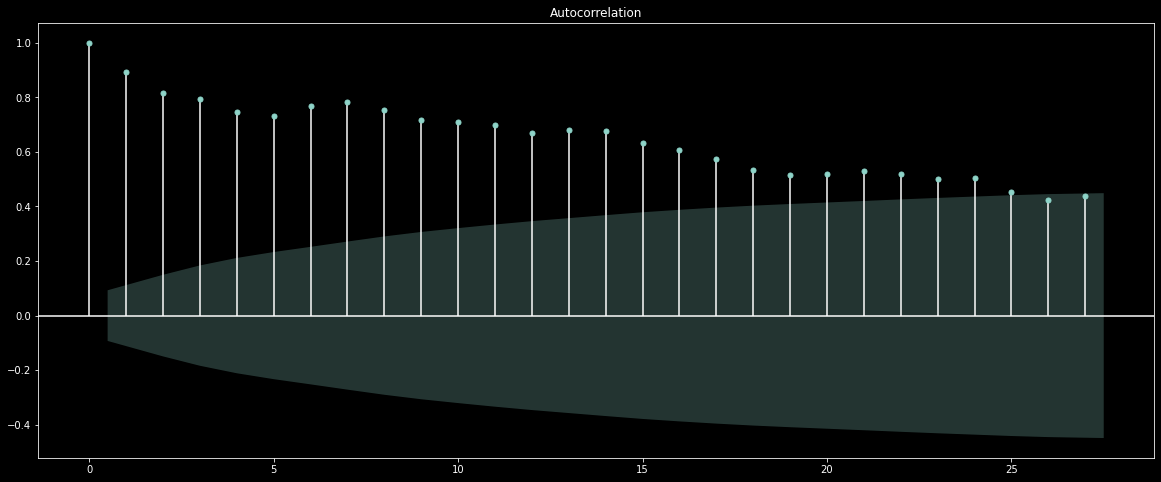

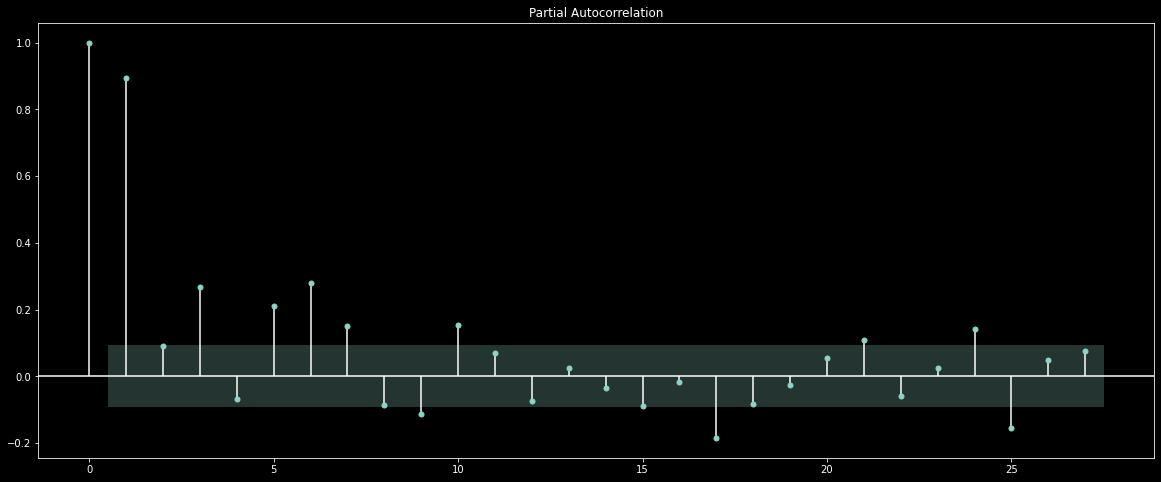

In [45]:
count = ts[~ts['rent_count'].isna()]['rent_count']
autocorrelation_plot(count)
plot_acf(count)
plot_pacf(count)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


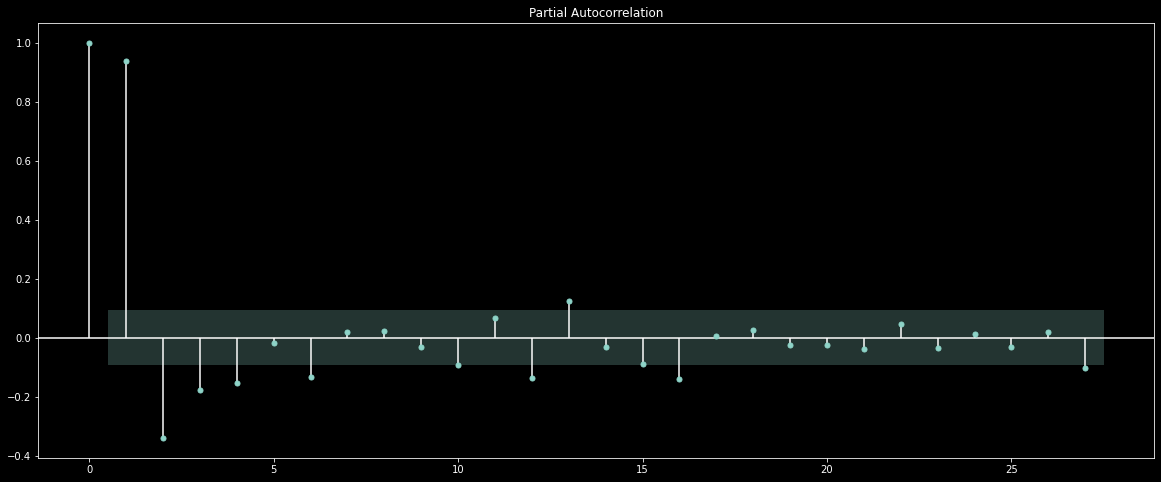

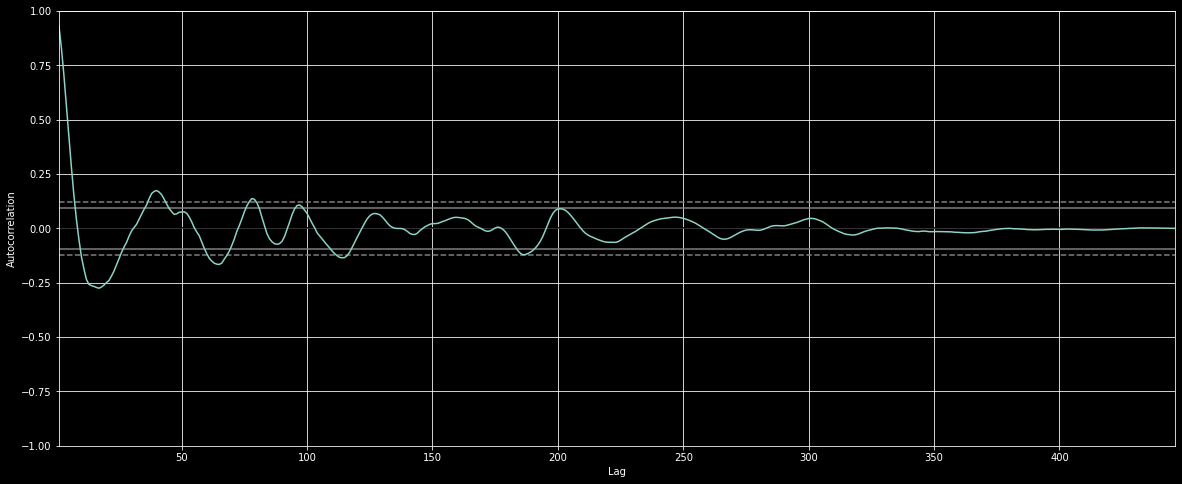

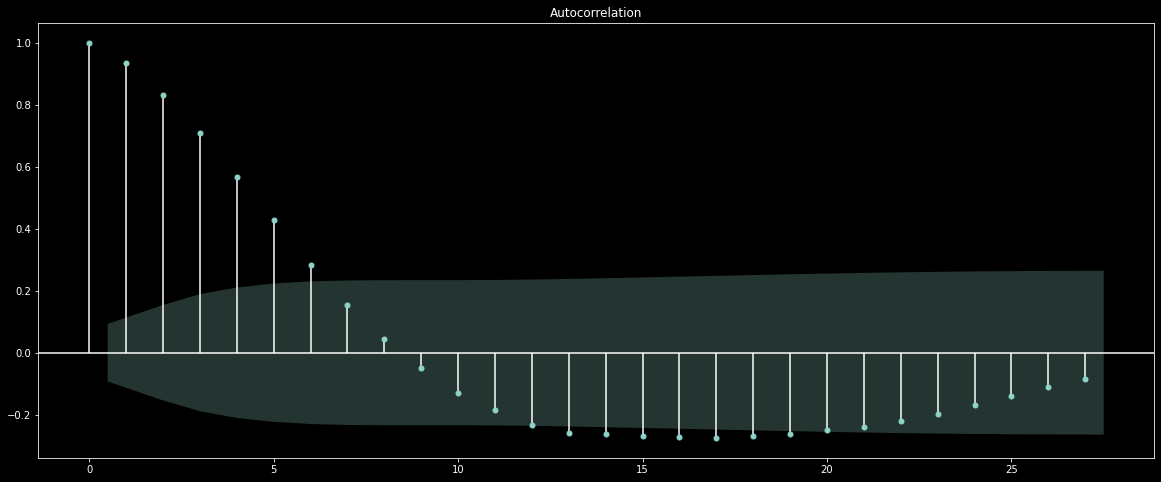

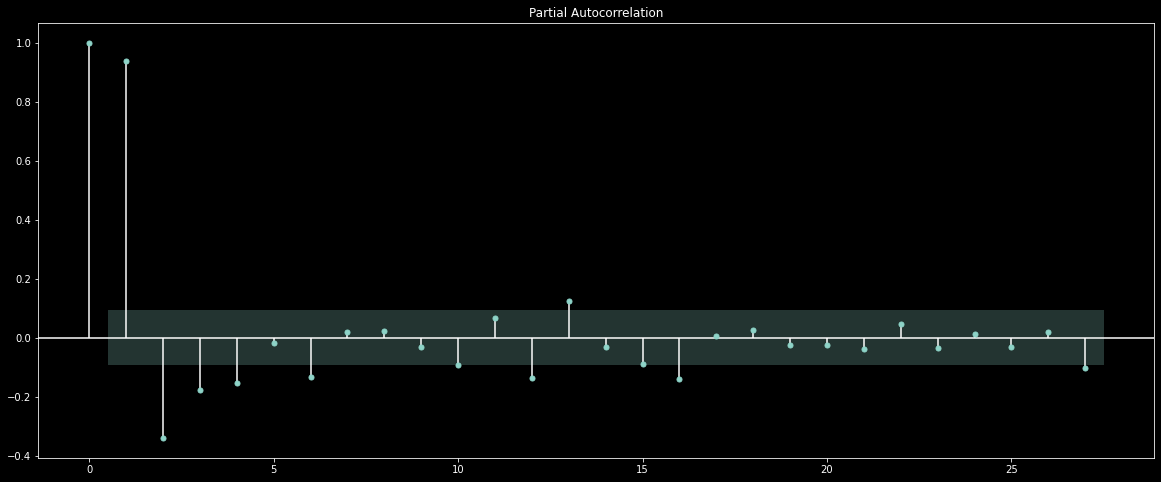

In [46]:
mean_price = ts[~ts['mean_price'].isna()]['mean_price']
autocorrelation_plot(mean_price)
plot_acf(mean_price)
plot_pacf(mean_price)

# Cross Correlation

The first plot shows the correlation with a forward lag

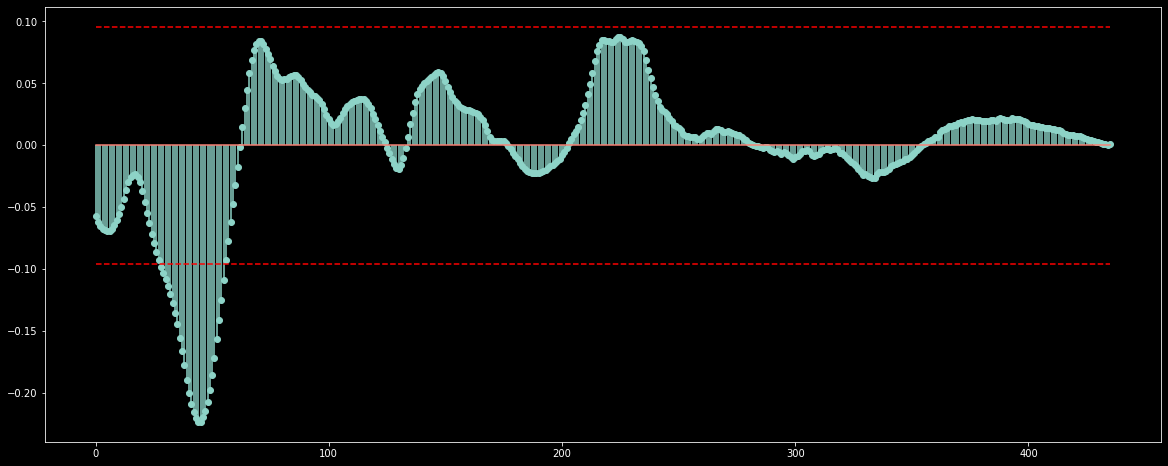

In [47]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

y = new_case_rate
x = mean_price[(mean_price.index >= y.index.min()) & (mean_price.index <= y.index.max())]

cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

Now we show the correlation with forward and backwards lag

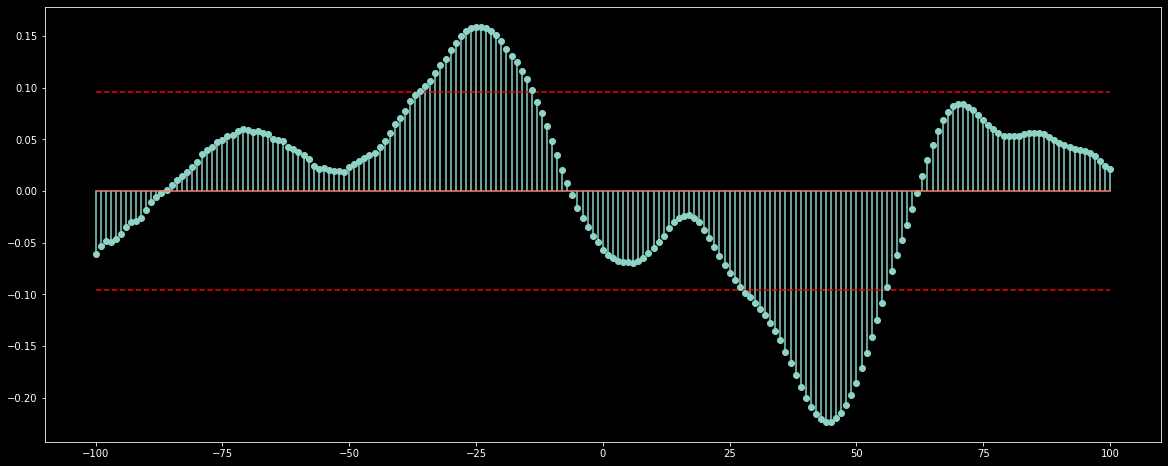

In [48]:
def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

ccorr_plot(x, y, 100)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

I think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

<AxesSubplot:>

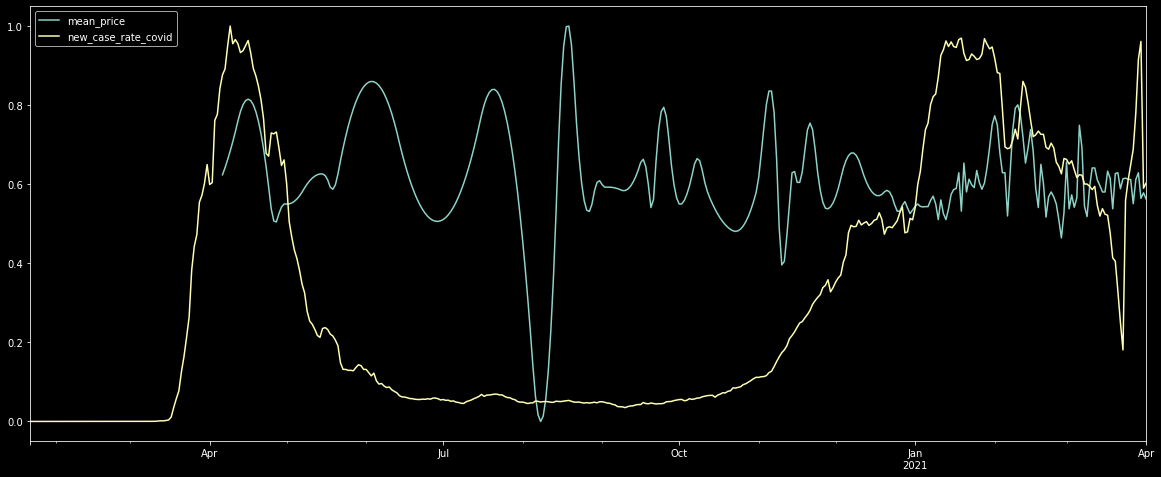

In [49]:
# x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
# y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)
df = pd.concat([x.shift(75), y], axis=1)
df.plot()

In [50]:
ts.corr()

mean_price  rent_count  median_price  \
mean_price                 1.000000   -0.063273      0.996995   
rent_count                -0.063273    1.000000     -0.091011   
median_price               0.996995   -0.091011      1.000000   
mean_price_per_sqft        0.149087   -0.198667      0.151512   
median_price_per_sqft      0.146020   -0.178853      0.145534   
...                             ...         ...           ...   
death_count_covid_resid   -0.009316    0.007219     -0.009542   
death_rate_covid_resid    -0.006299    0.011340     -0.008724   
test_count_covid_resid     0.113249   -0.004320      0.120181   
test_rate_covid_resid      0.113455   -0.004128      0.120331   
resid                      0.555168    0.009384      0.544847   

                         mean_price_per_sqft  median_price_per_sqft  \
mean_price                          0.149087               0.146020   
rent_count                         -0.198667              -0.178853   
median_price                        0.151512               0.145534   
mean_price_per_sqft                 1.000000               0.985895   
median_price_per_sqft               0.985895               1.000000   
...                                      ...                    ...   
death_count_covid_resid            -0.012616              -0.010698   
death_rate_covid_resid              0.007320               0.010946   
test_count_covid_resid              0.079862               0.087330   
test_rate_covid_resid               0.079665               0.087081   
resid                               0.052545               0.057614   

                         new_case_count_covid  new_death_count_covid  ...  \
mean_price                          -0.057154              -0.067461  ...   
rent_count                           0.420195              -0.032963  ...   
median_price                        -0.072321              -0.065129  ...   
mean_price_per_sqft                 -0.203286               0.147653  ...   
median_price_per_sqft               -0.196355               0.143823  ...   
...                                       ...                    ...  ...   
death_count_covid_resid             -0.138233               0.062826  ...   
death_rate_covid_resid              -0.117444               0.043534  ...   
test_count_covid_resid              -0.007727              -0.017753  ...   
test_rate_covid_resid               -0.007759              -0.017737  ...   
resid                               -0.008276              -0.013778  ...   

                         case_count_covid_resid  case_rate_covid_resid  \
mean_price                            -0.092369              -0.091651   
rent_count                            -0.020973              -0.020633   
median_price                          -0.088743              -0.088356   
mean_price_per_sqft                   -0.018033              -0.018037   
median_price_per_sqft                 -0.008926              -0.008739   
...                                         ...                    ...   
death_count_covid_resid                0.376196               0.377765   
death_rate_covid_resid                 0.322496               0.319384   
test_count_covid_resid                 0.213482               0.211269   
test_rate_covid_resid                  0.213628               0.211438   
resid                                 -0.011342              -0.010470   

                         death_count_covid_resid  death_rate_covid_resid  \
mean_price                             -0.009316               -0.006299   
rent_count                              0.007219                0.011340   
median_price                           -0.009542               -0.008724   
mean_price_per_sqft                    -0.012616                0.007320   
median_price_per_sqft                  -0.010698                0.010946   
...                                          ...                     ...   
death_count_covid_resid                 1.000

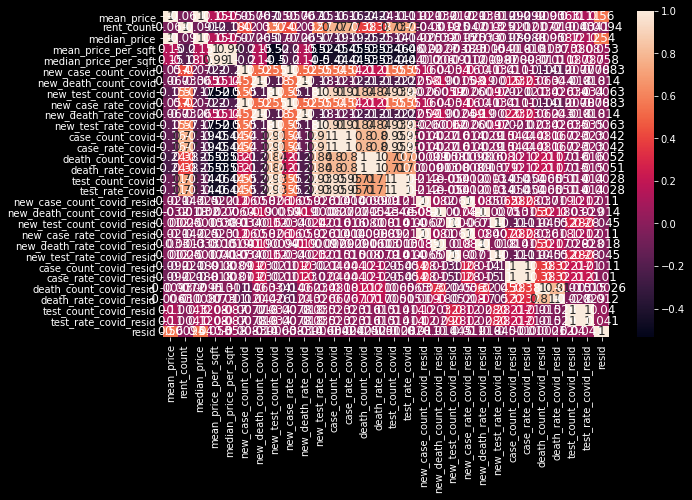

In [51]:
import seaborn as sns
corr = ts.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [52]:
# TODO: remove seasonality and apply diff


I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

In [53]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [54]:
print("COVID Results of Dicke-Fuller Test:")
dickey_fuller_test(case_rate)

COVID Results of Dicke-Fuller Test:
Test Statistic                   1.485118
p-value                          0.997469
#Lags Used                      18.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [55]:
print("Rent Results of Dicke-Fuller Test:")
dickey_fuller_test(mean_price)

Rent Results of Dicke-Fuller Test:
Test Statistic                -6.067641e+00
p-value                        1.171334e-07
#Lags Used                     1.500000e+01
Number of Observations Used    4.300000e+02
Critical Value (1%)           -3.445649e+00
Critical Value (5%)           -2.868285e+00
Critical Value (10%)          -2.570363e+00
dtype: float64


In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

## Making COVID TS stationary
I think we can use the results from the decomposition that we got earlier and get the residual

In [56]:
test = ts['case_rate_covid_resid'][~ts['case_rate_covid_resid'].isna()]

Test Statistic                  -3.469806
p-value                          0.008797
#Lags Used                      13.000000
Number of Observations Used    416.000000
Critical Value (1%)             -3.446168
Critical Value (5%)             -2.868513
Critical Value (10%)            -2.570484
dtype: float64


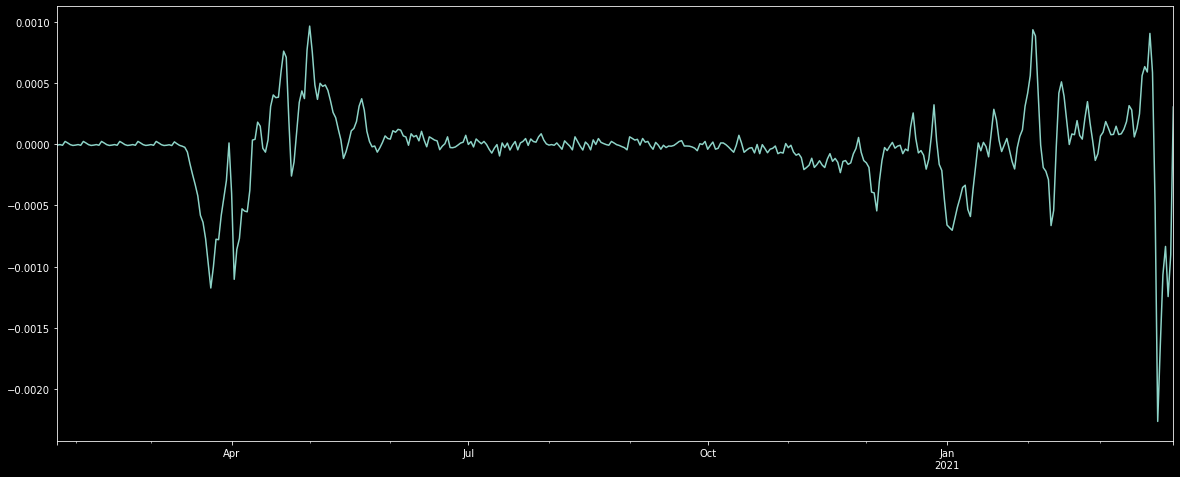

In [57]:
test.plot()
dickey_fuller_test(test)
# result_covid.plot()#%%

In [58]:
x = ts['resid'][(ts['resid'].index >= y.index.min()) & (ts['resid'].index <= y.index.max())].dropna()
x

2020-01-22   -0.003372
2020-01-23   -0.000507
2020-01-24   -0.002314
2020-01-25   -0.000583
2020-01-26   -0.006837
                ...   
2021-03-25   -0.011970
2021-03-26    0.026843
2021-03-27   -0.018619
2021-03-28    0.003463
2021-03-29    0.000835
Freq: D, Name: resid, Length: 433, dtype: float64

<AxesSubplot:>

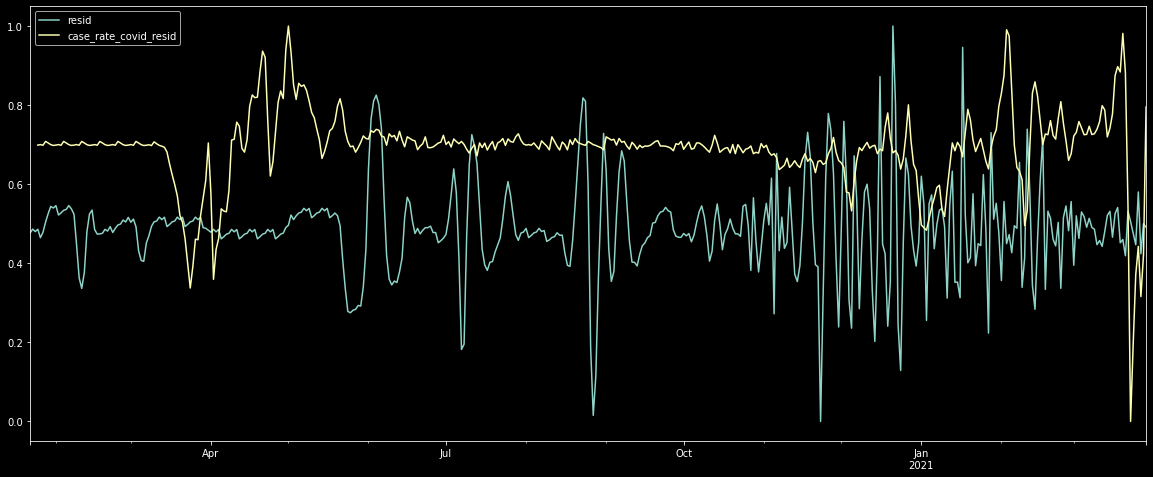

In [59]:
df = pd.concat([x, test], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df.plot()

In [60]:
df

resid  case_rate_covid_resid
2020-01-22  0.476565                    NaN
2020-01-23  0.486412                    NaN
2020-01-24  0.480200                    NaN
2020-01-25  0.486150               0.698969
2020-01-26  0.464656               0.700250
...              ...                    ...
2021-03-25  0.447011               0.371100
2021-03-26  0.580417               0.442675
2021-03-27  0.424159               0.315809
2021-03-28  0.500059               0.421588
2021-03-29  0.491026               0.795317

[433 rows x 2 columns]

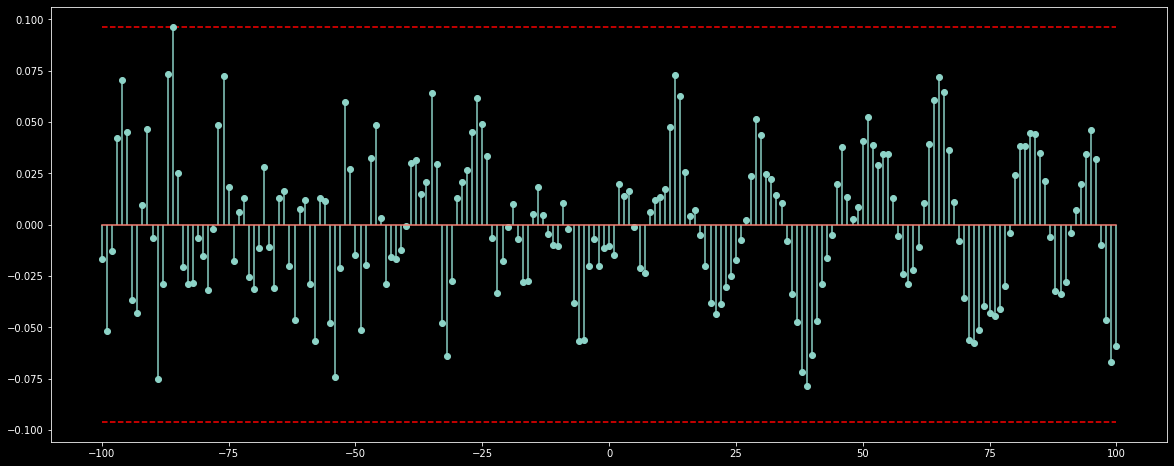

In [61]:
ccorr_plot(df['resid'].dropna(), df['case_rate_covid_resid'].dropna(), 100)

In [62]:
df.corr()

resid  case_rate_covid_resid
resid                  1.00000               -0.01047
case_rate_covid_resid -0.01047                1.00000

Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation.

# Model Evaluation

In [63]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# model = ARIMA(df['resid'], order=(3,0, 2))

In [64]:
model = pm.auto_arima(df['resid'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-588.096, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=633.595, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-586.286, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=163.125, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-584.384, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-94.127, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-585.722, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-748.137, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-746.551, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-726.666, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-786.842, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-764.874, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-766

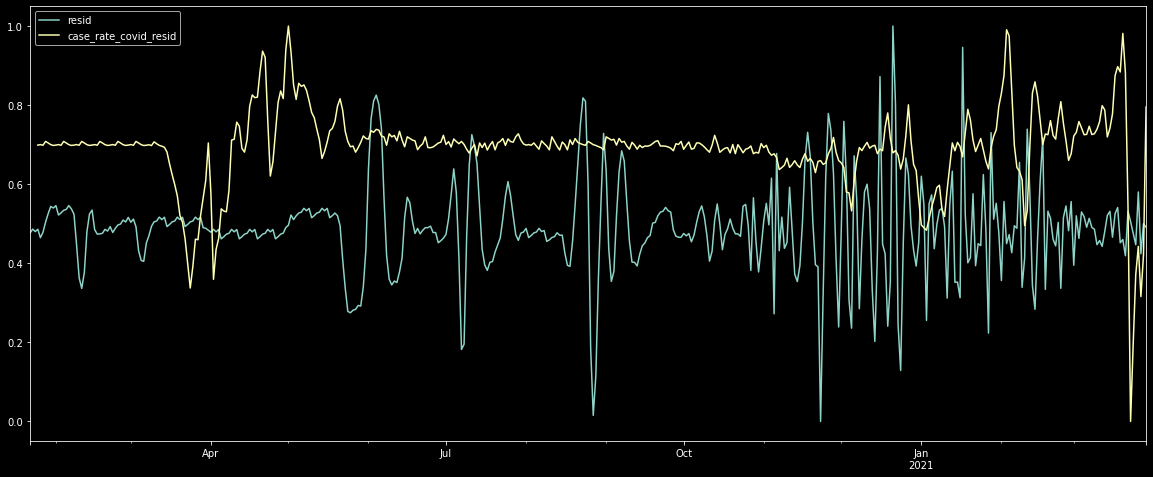

In [65]:
results_AR = model.fit(df['resid'], disp=1)
df.plot()
# plt.plot(results_AR.predict(), color='red')
# results_AR.plot_predict()
plt.show()

In [66]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

data = ts[['mean_price', 'median_price_per_sqft', 'new_case_rate_covid']]
data.fillna(data.min(), inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [67]:
df = data
# import for Granger's Causality Test

granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'median_price_per_sqft']], maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3145  , p=0.5752  , df_denom=453, df_num=1
ssr based chi2 test:   chi2=0.3166  , p=0.5736  , df=1
likelihood ratio test: chi2=0.3165  , p=0.5737  , df=1
parameter F test:         F=0.3145  , p=0.5752  , df_denom=453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9044  , p=0.4055  , df_denom=450, df_num=2
ssr based chi2 test:   chi2=1.8290  , p=0.4007  , df=2
likelihood ratio test: chi2=1.8253  , p=0.4015  , df=2
parameter F test:         F=0.9044  , p=0.4055  , df_denom=450, df_num=2


{1: ({'ssr_ftest': (0.31453926998366766, 0.575185264342641, 453.0, 1),
   'ssr_chi2test': (0.3166223115067383, 0.5736446178257406, 1),
   'lrtest': (0.3165124394599843, 0.5737111179524331, 1),
   'params_ftest': (0.3145392699836627, 0.575185264342641, 453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9044277135154837, 0.4055079437322693, 450.0, 2),
   'ssr_chi2test': (1.8289538206646447, 0.4007261870044559, 2),
   'lrtest': (1.8252877383138184, 0.4014614082448404, 2),
   'params_ftest': (0.9044277135153067, 0.40550794373234067, 450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [68]:
granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'new_case_rate_covid']], maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3633  , p=0.5470  , df_denom=453, df_num=1
ssr based chi2 test:   chi2=0.3657  , p=0.5454  , df=1
likelihood ratio test: chi2=0.3655  , p=0.5455  , df=1
parameter F test:         F=0.3633  , p=0.5470  , df_denom=453, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2703  , p=0.7633  , df_denom=450, df_num=2
ssr based chi2 test:   chi2=0.5466  , p=0.7608  , df=2
likelihood ratio test: chi2=0.5463  , p=0.7610  , df=2
parameter F test:         F=0.2703  , p=0.7633  , df_denom=450, df_num=2


{1: ({'ssr_ftest': (0.3632579188245011, 0.5470040086543071, 453.0, 1),
   'ssr_chi2test': (0.36566360040612034, 0.5453775181841599, 1),
   'lrtest': (0.36551706703949094, 0.5454580490394978, 1),
   'params_ftest': (0.36325791882471403, 0.5470040086541681, 453.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2703182344262533, 0.763260429963035, 450.0, 2),
   'ssr_chi2test': (0.5466435407286456, 0.7608479299214649, 2),
   'lrtest': (0.5463154307958575, 0.7609727610423419, 2),
   'params_ftest': (0.2703182344262336, 0.763260429963035, 450.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [69]:
model = VAR(data)
model_fit = model.fit()

In [70]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)


[[0.58068353 0.47827168 0.6022096 ]]


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
